In [ ]:
import pandas as pd
from pathlib import Path
import openpyxl as oxl
import numpy as np
import pkg_resources
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import t


In [2]:
# --- Import des données ---
df = pd.read_excel(Path("data") / "credit.xlsx")
df.info()
# 1000 lignes, 21 colonnes
# 12 colonnes numériques (int64), 9 non numériques (object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Cle                  1000 non-null   int64 
 1   Comptes              1000 non-null   int64 
 2   Duree_credit         1000 non-null   int64 
 3   Historique_credit    1000 non-null   object
 4   Objet_credit         1000 non-null   object
 5   Montant_credit       1000 non-null   int64 
 6   Epargne              1000 non-null   int64 
 7   Anciennete_emploi    1000 non-null   int64 
 8   Taux_effort          1000 non-null   int64 
 9   Situation_familiale  1000 non-null   object
 10  Garanties            1000 non-null   object
 11  Anciennete_domicile  1000 non-null   int64 
 12  Biens                1000 non-null   object
 13  Age                  1000 non-null   int64 
 14  Autres_credits       1000 non-null   object
 15  Statut_domicile      1000 non-null   object
 16  Nb_cred

In [3]:
# Encodage de la variable cible : 1 -> 0, 2 -> 1 puis afficher
df["Cible"] = df["Cible"].map({1: 0, 2: 1})
df["Cible"].value_counts()

Cible
0    700
1    300
Name: count, dtype: int64

In [ ]:
# --- Statistiques générales ---
ProfileReport(df, title="Rapport de données - Crédit")
# Pas de valeurs manquantes
# Garanties -> imbalanced
# Distributions semblent fortement assymétriques

# Corrélations fortes :
# entre Biens et Statut_domicile
# Montant_credit et Duree_credit

# A quoi correspondent les valeurs de :
# Historique_credit, Objet_credit, Situation_familiale, Garanties, Biens, Autres_credits, Statut_domicile, Type_emploi, Telephone

In [4]:
# Sélection des variables numériques et variables catégorielles
# Cle à exclure (car identification de l'observation)
# Variables numériques : Age, Montant_credit, Duree_credit
# Variables catégorielles : toutes les autres
var_num = df[["Age", "Montant_credit", "Duree_credit"]]
var_cat = df.drop(columns=["Cle", "Age", "Montant_credit", "Duree_credit"])

In [ ]:
# --- Statistiques descriptives - Univariées - Variables numériques ---
print("Statistiques descriptives variables numériques :")
var_num.describe()

In [ ]:
# Distributions
for col in var_num.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(var_num[col], kde=True)
    plt.title(f"Distribution de {col}")
    plt.show()
# Asymétrie pour Age, Montant_credit, et distribution irrégulière et asymétrique pour Duree_credit

In [ ]:
# Valeur aberrantes
# Boxplot
for col in var_num.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=var_num[col])
    plt.title(f"Boxplot de {col}")
    plt.show()
# 13 valeurs potentiellements atypiques dans Age
# Beaucoup dans Montant_credit
# 10 dans Duree_credit

In [8]:
def esd_test(y, alpha=0.05, max_outliers=20):
    """
    Test ESD pour la détection de valeurs aberrantes.

    Parameters:
        y (array-like): Données numériques
        alpha (float): Niveau de signification
        max_outliers (int): Nombre maximal de valeurs aberrantes à tester

    Returns:
        results (dict): Contient
            - 'R': statistiques de test
            - 'lambda': valeurs critiques
            - 'no_outliers': indices des points considérés comme aberrants
    """
    y = np.array(y, dtype=float)
    n = len(y)

    R = np.zeros(max_outliers)
    lam = np.zeros(max_outliers)
    y_work = y.copy()
    outlier_indices = []

    for i in range(max_outliers):
        mean_y = np.mean(y_work)
        std_y = np.std(y_work, ddof=1)
        if std_y == 0:
            break

        # Calcul de la statistique absolue standardisée
        ares = np.abs(y_work - mean_y) / std_y
        R[i] = np.max(ares)
        max_idx = np.argmax(ares)

        # Calcul de la valeur critique
        p = 1 - alpha / (2 * (n - i))
        t_crit = t.ppf(p, n - i - 1)
        lam[i] = t_crit * (n - i - 1) / np.sqrt((n - i - 2 + t_crit**2) * (n - i))

        # Si le maximum dépasse la valeur critique, c'est un outlier
        if R[i] > lam[i]:
            outlier_indices.append(np.where(y == y_work[max_idx])[0][0])

        # Retirer la valeur la plus extrême pour l'itération suivante
        y_work = np.delete(y_work, max_idx)

    return {
        "R": R[:len(outlier_indices)],
        "lambda": lam[:len(outlier_indices)],
        "no_outliers": outlier_indices
    }

In [9]:
# Application du test ESD de Rosner aux variables numériques avec affichage amélioré
for col in var_num.columns:
    data = var_num[col].dropna().values
    results = esd_test(data, alpha=0.05)

    # Conversion des valeurs pour affichage simple
    values = [int(data[i]) if np.issubdtype(data[i].dtype, np.integer) else float(data[i])
              for i in results["no_outliers"]]

    if values:
        print(f"Valeurs aberrantes détectées dans '{col}' : {values}")
    else:
        print(f"Aucune valeur aberrante détectée dans '{col}'.")

# Le test ESD n'a détecté aucune valeur aberrante dans la variable 'Age',
# 13 valeurs aberrantes dans la variable 'Montant_credit' 
# et 1 valeur aberrante dans la variable 'Duree_credit'.

Aucune valeur aberrante détectée dans 'Age'.
Valeurs aberrantes détectées dans 'Montant_credit' : [18424, 15945, 15857, 15672, 15653, 14896, 14782, 14555, 14421, 14318, 14179, 14027, 13756]
Valeurs aberrantes détectées dans 'Duree_credit' : [72]


In [ ]:
# --- Statistiques descriptives - Univariées - Variables catégorielles ---
print("Statistiques descriptives variables catégorielles :")
var_cat.describe()

In [ ]:
# --- Représentation variable Cible ---
prop = df["Cible"].value_counts(normalize=True) * 100
prop.plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Proportion des classes de la variable Cible")
plt.xlabel("Cible")
plt.ylabel("Pourcentage (%)")
plt.show()

In [ ]:
# Barplot
for col in var_cat.columns:
    plt.figure(figsize=(8, 4))
    var_cat[col].value_counts().plot(kind="bar")
    plt.title(f"Répartition de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()

In [ ]:
# Statistiques descriptives - Multivariées
# Par rapport à la variable Cible (en enlevant les variables continues numériques)
# Barplots croisés
for col in df.drop(
    columns=["Cible", "Cle", "Montant_credit", "Duree_credit", "Age"]
).columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue="Cible", data=df)
    plt.title(f"{col} vs Cible")
    plt.show()

In [ ]:
# Histogrammes empilés
for col in df.drop(
    columns=["Cible", "Cle", "Montant_credit", "Duree_credit", "Age"]
).columns:
    cross_tab = pd.crosstab(df[col], df["Cible"], normalize="index")
    cross_tab.plot(kind="bar", stacked=True, figsize=(6, 4))
    plt.title(f"Proportion de Cible par {col}")
    plt.ylabel("Proportion")
    plt.show()

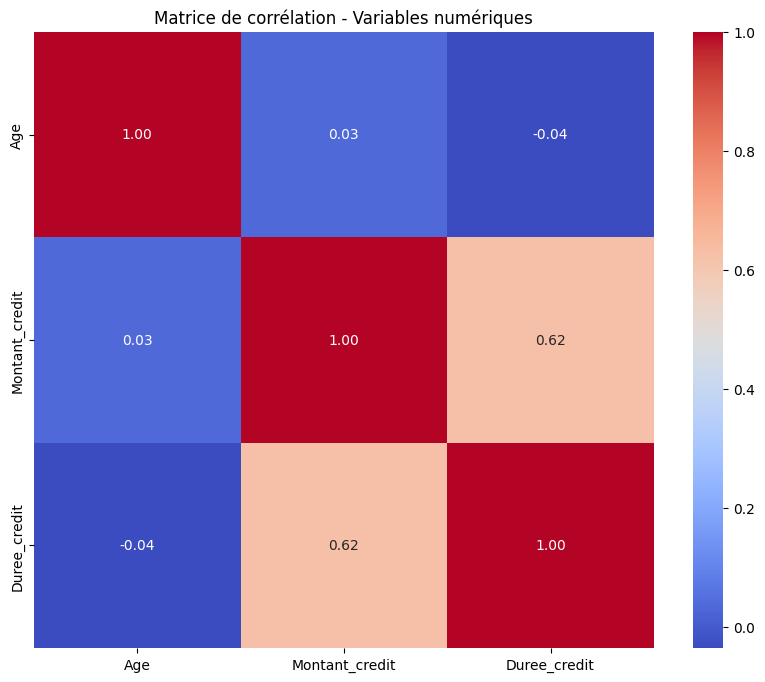

In [10]:
# --- Corrélations ---
# Pearson
plt.figure(figsize=(10, 8))
corr_matrix = var_num.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation - Variables numériques")
plt.show()
# Corrélation de 0.62 entre Montant_credit et Duree_credit

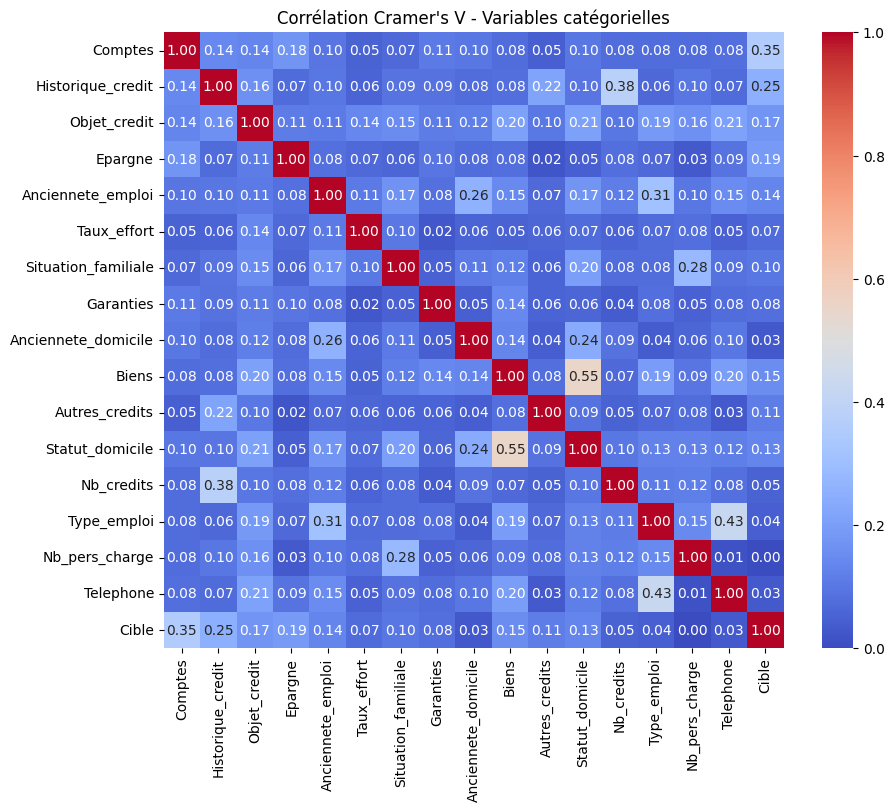

In [ ]:
# Khi2 et CramersV
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

cat_cols = var_cat.columns
cramers = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))), index=cat_cols, columns=cat_cols
)
for col1 in cat_cols:
    for col2 in cat_cols:
        cramers.loc[col1, col2] = cramers_v(var_cat[col1], var_cat[col2])
plt.figure(figsize=(10, 8))
sns.heatmap(cramers, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation Cramer's V - Variables catégorielles")
plt.show()
# Corrélation de 0.55 entre Statut_domicile et Biens
# Corrélation de 0.43 entre Type_emploi et Telephone

In [14]:
# --- Création de variables croisées --- 
# Pour les variables fortement corrélées
# Intéraction numérique : Montant_credit et Duree_credit
df["interaction_montant_duree"] = df["Montant_credit"] * df["Duree_credit"]
# Intéraction catégorielle : Statut_domicile et Biens, Type_emploi et Telephone
df["interaction_domicile_biens"] = (
    df["Statut_domicile"].astype(str) + "_" + df["Biens"].astype(str)
)
df["interaction_emploi_telephone"] = (
    df["Type_emploi"].astype(str) + "_" + df["Telephone"].astype(str)
)

print(list(df.columns))

['Cle', 'Comptes', 'Duree_credit', 'Historique_credit', 'Objet_credit', 'Montant_credit', 'Epargne', 'Anciennete_emploi', 'Taux_effort', 'Situation_familiale', 'Garanties', 'Anciennete_domicile', 'Biens', 'Age', 'Autres_credits', 'Statut_domicile', 'Nb_credits', 'Type_emploi', 'Nb_pers_charge', 'Telephone', 'Cible', 'interaction_montant_duree', 'interaction_domicile_biens', 'interaction_emploi_telephone']


In [ ]:
# --- Fine classing et coarse classing ---
# Fine classing à faire que sur les variables continues

# Obj_credit plus de 5 catégories (9)
# => on fais coarse classing UNIQUEMENT sur cette variables catégorielle

In [ ]:
# Séparation Train et Test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Cle']), # on enleve Cle car inutile, en enlève pas Cible car on en a besoin après
    df['Cle'],
    test_size=0.2,
    random_state=42
)

In [ ]:
# Code automatisé
# Paramètres
n_bins = 10           # Nombre de bacs pour fine classing
threshold = 0.15      # Seuil de fusion pour coarse classing

# Dictionnaire pour stocker les résultats
woe_iv_results = {}

# Boucle sur chaque variable numérique
for var in var_num:
    print(f"\n--- Traitement de {var} ---")
    
    # 1. Fine classing
    bin_fine_col = f"{var}_bin_fine"
    X_train[bin_fine_col] = pd.qcut(X_train[var], q=n_bins, duplicates='drop')
    
    # 2. Calcul WOE/IV sur bacs fins
    woe_table_fine, iv_fine = woe_iv(X_train, bin_fine_col, "Cible")
    print(f"IV fin ({var}) = {iv_fine:.4f}")
    print(woe_table_fine)
    
    # 3. Coarse classing
    woe_table_fine = woe_table_fine.sort_values("WOE")
    woe_table_fine["WOE_shift"] = woe_table_fine["WOE"].shift()
    woe_table_fine["merge_group"] = (abs(woe_table_fine["WOE"] - woe_table_fine["WOE_shift"]) > threshold).cumsum()
    
    # Mapping coarse bins
    mapping = woe_table_fine["merge_group"].to_dict()
    bin_coarse_col = f"{var}_bin_coarse"
    X_train[bin_coarse_col] = X_train[bin_fine_col].map(mapping)
    
    # 4. WOE/IV sur bacs grossiers
    woe_table_coarse, iv_coarse = woe_iv(X_train, bin_coarse_col, "Cible")
    print(f"IV coarse ({var}) = {iv_coarse:.4f}")
    print(woe_table_coarse)
    
    # Stocker les résultats
    woe_iv_results[var] = {
        "fine": (woe_table_fine, iv_fine),
        "coarse": (woe_table_coarse, iv_coarse)
    }


In [ ]:
# Objet_Credit

In [ ]:
# --- Encodage des variables catégorielles ---
